# QCoDeS Example with Alazar ATS 9360
In this notebook, we want to show how to setup an Alazar ATS9360 card and its acquisition controller in qcodes to acquire data. In this example, we only demonstrate how to setup the card for an acquisition job without physically contected to any other instrument like wave form generators. Although, this notebook is aimed for ATS9360, most of its content can be useful for other models of Alazar cards having their qcodes driver.

### Required imports

In [1]:
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr
from qcodes.utils.dataset import doNd
from qcodes.dataset.plotting import plot_by_id 

### Setting up Alazar and performing an acquisition

First, lets list all the Alazar boards connected to this machine. In most cases this will probably only be a single one:

In [2]:
ATSdriver.AlazarTech_ATS.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

Now, we create an instance of alazar:

In [3]:
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1')

This prints all information about this Alazar card:

In [4]:
ats_inst.get_idn()  # or .IDN()

{'firmware': '21.09',
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970396',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.5.1',
 'SDK_version': '6.5.1',
 'latest_cal_date': '25-01-17',
 'memory_size': '4294967294',
 'asopc_type': 1763017568,
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

The parameters on the Alazar card are set in a slightly unusual way. As communicating with the card is slow, and sometimes multiple parameters have to be set with a single "command", we use a context manager that takes care of syncing all the paramters to the card after we set them. Remember to sync parameter values to Alazar card when changing values of those parameters which correspond to Alazar card settings (for example sample_rate parameter is a global "setting" for the card, while for example records_per_buffer is a parameter of the acquisition process and is set to the card only when performing an acquisition):

In [5]:
with ats_inst.syncing():
    ats_inst.clock_source('INTERNAL_CLOCK')
    ats_inst.sample_rate(1_000_000_000)
    ats_inst.clock_edge('CLOCK_EDGE_RISING')
    ats_inst.decimation(1)
    ats_inst.coupling1('DC')
    ats_inst.coupling2('DC')
    ats_inst.channel_range1(.4)
    ats_inst.channel_range2(.4)
    ats_inst.impedance1(50)
    ats_inst.impedance2(50)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1('TRIG_ENGINE_J')
    ats_inst.trigger_source1('EXTERNAL')
    ats_inst.trigger_slope1('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level1(160)
    ats_inst.trigger_engine2('TRIG_ENGINE_K')
    ats_inst.trigger_source2('DISABLE')
    ats_inst.trigger_slope2('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level2(128)
    ats_inst.external_trigger_coupling('DC')
    ats_inst.external_trigger_range('ETR_2V5')
    ats_inst.trigger_delay(0)
    ats_inst.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    ats_inst.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on
    
    # Note that we set this parameter to a non-0 value for demonstration purposes - doing so allows
    # to perform an acquisition using just the Alazar card without any additional hardware.
    # Read Alazar SDK manual about `AlazarSetTriggerTimeOut` function for more information.
    ats_inst.timeout_ticks(0)

The alazar qcodes driver is only for setting and/ or getting parameters defined in the manual of the card. Other acquisition functionalities at the moment are available in the module called ATS_acquisition_controllers. So, we instantiate this module with the already instantiated Alazar driver: 

In [6]:
acquisition_controller = ats_contr.Demodulation_AcquisitionController(name='acquisition_controller', 
                                                                      demodulation_frequency=10e6, 
                                                                      alazar_name='Alazar1')

This following command is specific to this acquisition controller. The kwargs provided here are being forwarded to instrument's acquire function (ats_inst.acquire()).

This way, it becomes (arguably) easy to change acquisition specific settings from the ipython notebook.

In [7]:
acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=74,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

Getting the value of the parameter acquisition of the instrument acquisition_controller performes the entire acquisition protocol. The type/shape/kind of the returned value depends on the specific implementation of the acquisition controller in use. In this particular example, the output will be a single value (see the docstring of Demodulation_AcquisitionController).

In [8]:
acquisition_controller.acquisition()

4.430443717981646

Let's have look at the snapshot of the Alazar instance:

In [9]:
ats_inst.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'Alazar1_IDN',
   'value': None,
   'raw_value': None,
   'ts': None,
   'post_delay': 0,
   'name': 'IDN',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'unit': '',
   'label': 'IDN',
   'inter_delay': 0,
   'vals': '<Anything>'},
  'clock_source': {'__class__': 'qcodes.instrument_drivers.AlazarTech.utils.TraceParameter',
   'full_name': 'Alazar1_clock_source',
   'value': 'INTERNAL_CLOCK',
   'raw_value': 1,
   'ts': '2020-11-26 13:53:42',
   'post_delay': 0,
   'val_mapping': {'INTERNAL_CLOCK': 1,
    'FAST_EXTERNAL_CLOCK': 2,
    'EXTERNAL_CLOCK_10MHz_REF': 7},
   'name': 'clock_source',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1'

Finally, the following shows that Alazar driver and its acquisition controller work well within a the QCoDeS measurement using a dummy parameter and do1d function:

In [10]:
dummy = parameter.ManualParameter(name="dummy")
doNd.do1d(dummy, 0, 50, 51, 0.5, acquisition_controller.acquisition, do_plot=False)

Starting experimental run with id: 20. 


(results #20@C:\Users\Farzad\experiments.db
 ------------------------------------------
 dummy - numeric
 acquisition_controller_acquisition - numeric,
 [None],
 [None])

Let's have a quick look at the acquisition result:

([<AxesSubplot:title={'center':'Run #20, Experiment exp (no sample1)'}, xlabel='dummy', ylabel='acquisition'>],
 [None])

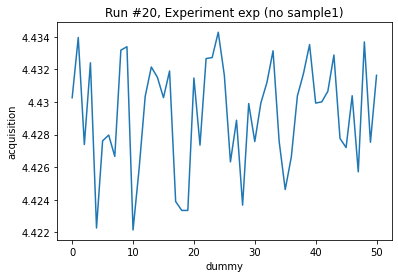

In [11]:
plot_by_id(20)

### Looking for extra functionalities?

It is expected that the users will implement acquisitions to fit their needs. One can visit [this link](https://github.com/qdev-dk/qdev-wrappers/tree/master/qdev_wrappers/alazar_controllers), where other controller examples for Alazar can be found. Also, it might be useful to check out [this notebook](https://github.com/qdev-dk/qdev-wrappers/blob/master/examples/Alazar/Qcodes%20example%20with%20Alazar%20ATS9360.ipynb) to get to know how to use these controllers.